In [1]:
import sys
import numpy as np
import librosa

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import os

# import chainer
# from chainer import cuda, Variable, Chain, serializers
# import chainer.functions as F
# import chainer.links as L

# sys.path.append('../networks/')
from network import *

%matplotlib inline
import matplotlib.pyplot as plt

# plt.style.use('ggplot')

In [2]:
logmel_Res = []
freqs = range(22050, 0, -30)
wav_len = int(44100 * 1.5)
fs = 44100

for freq in freqs:
    response = np.zeros([64])
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
    melspec = librosa.feature.melspectrogram(x, 44100, n_fft=800, hop_length=150, n_mels=64) # (64, 442)
    logmel = librosa.logamplitude(melspec) # (64, 442)
    res = np.mean(logmel[:, 10: 140], axis=1) # (64,)
    logmel_Res.append(res)
    
logmel_Res = np.array(logmel_Res) # (800, 64)
print logmel_Res
print logmel_Res.shape
# mel_freq = 7995 - 10 * np.argmax(logmel_Res, axis=0)
# print mel_freq

[[-100.         -100.         -100.         ..., -100.         -100.         -100.        ]
 [ -78.65875113  -78.65875113  -78.65875113 ...,  -78.65875113
   -75.22181968    0.19323521]
 [ -76.89770153  -76.89770153  -76.89770153 ...,  -76.89770153
   -76.89770153    3.0561606 ]
 ..., 
 [  26.59393781   26.47354719   14.31098716 ...,  -53.0871473   -53.0871473
   -53.0871473 ]
 [  27.92412404   22.18173005   -8.63947558 ...,  -51.97914769
   -51.97914769  -51.97914769]
 [  26.52054639   12.8822113    -5.07490233 ...,  -52.14590866
   -52.14590866  -52.14590866]]
(735, 64)


In [3]:
mel_freq = 22050 -30 * np.argmax(logmel_Res, axis=0)
print mel_freq, mel_freq.shape

[   60   120   180   240   300   360   420   480   540   600   660   720
   810   870   930   990  1050  1110  1200  1260  1350  1440  1530  1650
  1740  1860  1980  2100  2250  2400  2550  2700  2910  3090  3300  3510
  3750  3960  4230  4530  4800  5130  5460  5820  6210  6600  7050  7500
  7980  8520  9060  9660 10290 10980 11700 12450 13290 14130 15060 16050
 17100 18240 19410 20700] (64,)


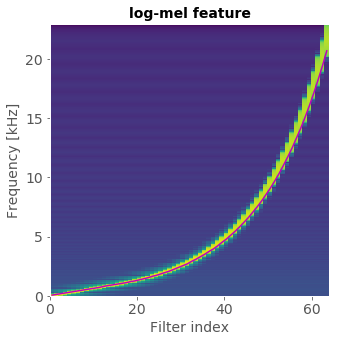

In [58]:
fig = plt.figure(figsize=(5, 5))

x, y = np.meshgrid(np.arange(65), np.arange(735) / 735. * 23) # (735, 65) (735, 65)
# print x.shape, y.shape
# print x
# print y
# plt.pcolor(x, y, np.flipud(logmel_Res)) # np.flipud 矩阵上下翻转
plt.pcolor(x, y, np.flipud(logmel_Res)) # np.flipud 矩阵上下翻转
# plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., 'm')
plt.title('log-mel feature', fontsize=14, fontweight='bold')
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

In [4]:
# Create sin waves

# freqs = range(7995, 0, -10)
freqs = range(22050, 0, -30)
wav_len = int(44100 * 1.5)

fs = 44100
X = []

for freq in freqs:
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
    X.append(x[np.newaxis, :])
X = np.array(X).astype(np.float32) # (735, 1, fs*1.5)
print X.shape

(735, 1, 66150)


In [29]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

# model = torch.load('../model/M9_fold1_v2_epoch250.pkl')
model = torch.load('../model/M9_v2_fold0_v2_f32_epoch160.pkl')
model.cuda()

# print model
# Calculate pool2 of EnvNet
batchsize = 32
Res1 = []
Res2 = []
Res3 = []
N = 735

Xt = torch.from_numpy(X)
Xt = Xt.cuda()
Xt = Variable(Xt)
for i in xrange(0, N, batchsize):
    print i
    x = Xt[i: i+batchsize]
    x1 = model.relu(model.bn1_1(model.conv1_1(x)))
    x2 = model.relu(model.bn1_2(model.conv1_2(x)))
    x3 = model.relu(model.bn1_3(model.conv1_3(x)))

    x1 = model.relu(model.bn2_1(model.conv2_1(x1)))
    x2 = model.relu(model.bn2_2(model.conv2_2(x2)))
    x3 = model.relu(model.bn2_3(model.conv2_3(x3)))
    
    x1 = model.pool2_1(x1)
    x2 = model.pool2_2(x2)
    x3 = model.pool2_3(x3)  # (batchSize, 64L, 441L)
        
    res1 = torch.mean(x1, dim=2)
    Res1.extend(res1.data.cpu().numpy())

    res2 = torch.mean(x2, dim=2)
    Res2.extend(res2.data.cpu().numpy())
    
    res3 = torch.mean(x3, dim=2)
    Res3.extend(res3.data.cpu().numpy())
# print Res
Res1 = np.asarray(Res1)
Res2 = np.asarray(Res2)
Res3 = np.asarray(Res3)

print Res1.shape
print Res2.shape
print Res3.shape

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
(735, 32)
(735, 32)
(735, 32)


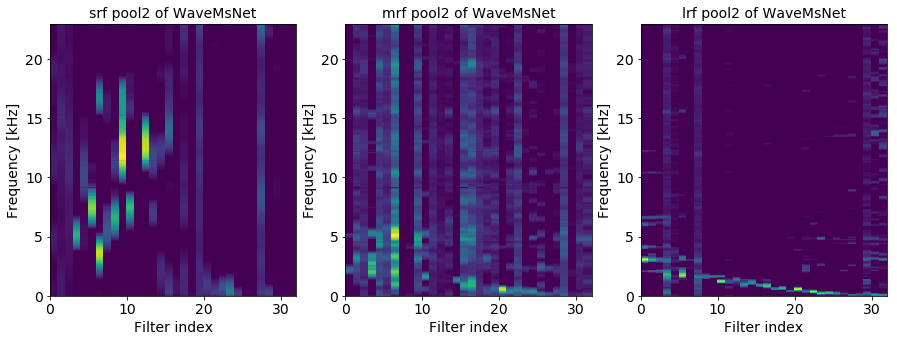

In [30]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(Res1))
plt.title('srf pool2 of WaveMsNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1,3,2)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(Res2))
plt.title('mrf pool2 of WaveMsNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1,3,3)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(Res3))
plt.title('lrf pool2 of WaveMsNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

[[ 0.01474616  0.          0.         ...,  0.08115145  0.1408973   0.        ]
 [ 0.00328461  0.54544723  0.27368692 ...,  0.02324355  0.03695858  0.        ]
 [ 0.00652171  0.62959218  0.32947335 ...,  0.03912469  0.06225086  0.        ]
 ..., 
 [ 0.0638426   0.70648438  0.14178552 ...,  0.06364454  0.1339249   0.        ]
 [ 0.0522741   0.65825939  0.12371363 ...,  0.04816592  0.10323083  0.        ]
 [ 0.0422831   0.56741697  0.09525915 ...,  0.02867008  0.06908461  0.        ]]
(735, 32)
[381 242 395 567 410 496 618 558 521 356 493   0 331 353 338 284 723  25
 728   5 702 726 709 726 727 731   0   5 727 118 727 484]
[10620 14790 10200  5040  9750  7170  3510  5310  6420 11370  7260 22050
 12120 11460 11910 13530   360 21300   210 21900   990   270   780   270
   240   120 22050 21900   240 18510   240  7530] (32,)
sort_index1:  [25 18 28 24 30 23 21 16 22 20  6  3  7  8  5 10 31  4  2  0  9 13 14 12 15
  1 29 17 27 19 11 26]
sorted_Res1:  [[ 0.07540032  0.20952304  0.15635955 ...,

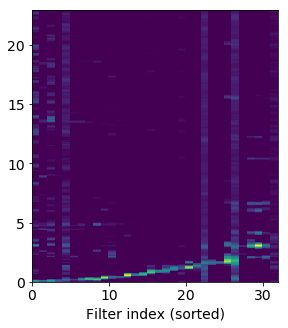

In [31]:
center_freq1 = 22050 - 30 * np.argmax(Res1, axis=0)
print Res1
print Res1.shape
print np.argmax(Res1, axis=0)
print center_freq1, center_freq1.shape
center_freq2 = 22050 - 30 * np.argmax(Res2, axis=0)
center_freq3 = 22050 - 30 * np.argmax(Res3, axis=0)
# rm_index = [5, 6, 7, 8, 18] # filters which respond to all frequency area are removed
# center_freq[rm_index] = 8000
sort_index1 = np.argsort(center_freq1)[:33]
sort_index2 = np.argsort(center_freq2)[:33]
sort_index3 = np.argsort(center_freq3)[:33]

print 'sort_index1: ', sort_index1

sorted_Res1 = Res1[:, sort_index1]
sorted_Res2 = Res2[:, sort_index2]
sorted_Res3 = Res3[:, sort_index3]

print 'sorted_Res1: ', sorted_Res1, sorted_Res1.shape

sorted_center_freq1 = center_freq1[sort_index1]
sorted_center_freq2 = center_freq2[sort_index2]
sorted_center_freq3 = center_freq3[sort_index3]
print 'scf: ', sorted_center_freq1

avg_mel = np.mean(mel_freq)
avg_center_freq1 = int(np.mean(center_freq1))
avg_center_freq2 = int(np.mean(center_freq2))
avg_center_freq3 = int(np.mean(center_freq3))
print avg_mel, avg_center_freq1, avg_center_freq2, avg_center_freq3

fig = plt.figure(figsize=(15, 5))


# plt.subplot(1, 3, 1)
# x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
# plt.pcolor(x, y, np.flipud(sorted_Res1))
# # plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., 'm')
# # plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq1 / 1000., 'm')
# # plt.title('scale Stk I responses(sorted)', fontsize=14)
# plt.xlabel('Filter index (sorted)', fontsize=14)
# plt.ylabel('Frequency [kHz]', fontsize=14)
# plt.tick_params(labelsize=14)
# plt.colorbar()

# plt.subplot(1, 3, 2)
# x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
# plt.pcolor(x, y, np.flipud(sorted_Res2))
# # plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., 'm')
# # plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq2 / 1000., 'm')
# # plt.title('mrf responses(sorted)', fontsize=14)
# plt.xlabel('Filter index (sorted)', fontsize=14)
# # plt.ylabel('Frequency [kHz]', fontsize=14)
# plt.tick_params(labelsize=14)

plt.subplot(1, 3, 3)
x, y = np.meshgrid(np.arange(33), np.arange(735) / 735. * 23)
plt.pcolor(x, y, np.flipud(sorted_Res3))
# plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., 'm')
# plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq3 / 1000., 'm')
# plt.title('lrf responses(sorted)', fontsize=14)
plt.xlabel('Filter index (sorted)', fontsize=14)
# plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

# plt.savefig('responses.pdf', bbox_inches='tight')

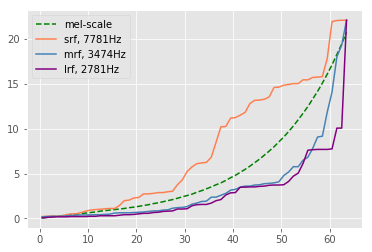

In [140]:
fig = plt.figure()
plt.plot(np.arange(64) * (64) / 64. + 0.5 , mel_freq / 1000., label='mel-scale', color='g', linestyle='--')
plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq1 / 1000., label='srf, '+str(avg_center_freq1)+'Hz', color='coral')
plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq2 / 1000., label='mrf, '+str(avg_center_freq2)+'Hz', color='steelblue')
plt.plot(np.arange(64) * (64) / 64. + 0.5 , sorted_center_freq3 / 1000., label='lrf, '+str(avg_center_freq3)+'Hz', color='purple')
plt.legend(loc='upper left')
plt.show()

# plt.savefig('center f.pdf', bbox_inches='tight')

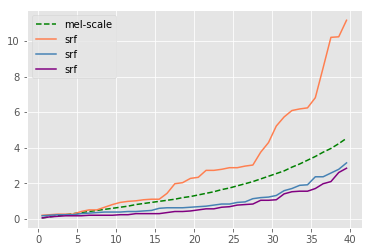

In [92]:
fig = plt.figure()
plt.plot(np.arange(40) * (40) / 40. + 0.5 , mel_freq[:40] / 1000., label='mel-scale', color='g', linestyle='--')
plt.plot(np.arange(40) * (40) / 40. + 0.5 , sorted_center_freq1[:40] / 1000., label='srf, ', color='coral')
plt.plot(np.arange(40) * (40) / 40. + 0.5 , sorted_center_freq2[:40] / 1000., label='mrf', color='steelblue')
plt.plot(np.arange(40) * (40) / 40. + 0.5 , sorted_center_freq3[:40] / 1000., label='lrf', color='purple')
plt.legend(loc='upper left')
plt.show()


In [34]:
np.savetxt('../figures/txt/response.txt', Res)
np.savetxt('../figures/txt/sorted_response.txt', sorted_Res)
np.savetxt('../figures/txt/logmel_response.txt', logmel_Res)
np.savetxt('../figures/txt/mel_freq.txt', mel_freq)